# RTED-TDS co-simulation

## Import case

In [2]:
import andes
import numpy as np
from andes.interop.pandapower import to_pandapower, make_link_table, \
    runopp_map, add_gencost, build_group_table
andes.config_logger(stream_level=20)

import pandas as pd
import pandapower as pp
from math import ceil, floor                                                                                          

import os
from tqdm import tqdm

import matplotlib.pyplot as plt

import gurobipy as gb

In [3]:
print(andes.__version__)
print(pp.__version__)

1.6.2.post30.dev0+gb479fa95
2.7.0


In [4]:
plt.rcParams["figure.dpi"] = 200
figsize=(5,3)

In [5]:
def var_table(ss, mdl, src, a=[], attr='v'):
    mdl = getattr(ss, mdl)
    var = getattr(mdl, src)
    out = pd.DataFrame()
    out['name'] = mdl.name.v
    out['idx'] = mdl.idx.v
    out[src] = getattr(var, attr)
    if a:
        out = out.iloc[a]
    return out

In [6]:
# ss0 is used for PP conversion
dir_path = os.path.abspath('..')
case_path = '/case/ieee39_base.xlsx'
case = dir_path + case_path
ssa = andes.load(case,
                 setup=True,
                 no_output=True,
                 default_config=False)
ss0 = andes.load(case,
                 setup=True,
                 no_output=True,
                 default_config=False)

Working directory: "/Users/jinningwang/Documents/work/andes/jwang/notes"
> Loaded config from file "/Users/jinningwang/.andes/andes.rc"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Parsing input file "/Users/jinningwang/Documents/work/andes/jwang/case/ieee39_base.xlsx"...
Input file parsed in 0.2394 seconds.
ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0400 seconds.
Working directory: "/Users/jinningwang/Documents/work/andes/jwang/notes"
> Loaded config from file "/Users/jinningwang/.andes/andes.rc"
> Reloaded generated Python code of module "pycode".
Parsing input file "/Users/jinningwang/Documents/work/andes/jwang/case/ieee39_base.xlsx"...
Input file parsed in 0.1015 seconds.
ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0378 seconds.


Turn on ``numba`` can accelerate TDS.

In [7]:
ssa.config.numba

1

Set as constant load

In [8]:
# use constant power model for PQ (we will come back to this later)

ssa.PQ.config.p2p = 1
ssa.PQ.config.q2q = 1
ssa.PQ.config.p2z = 0
ssa.PQ.config.q2z = 0

# turn off under-voltage PQ-to-Z conversion
ssa.PQ.pq2z = 0

## Load synthetic

Now the load flucation mag. 20%, whereas the daily flucation of PJM load is about 20%.

ANDES total load is: 46.8512 p.u.
   time            h10       s10
0     0  101841.971067  1.183924
1   300  101848.811867  1.185197


Text(0.5, 0, 'Time [s]')

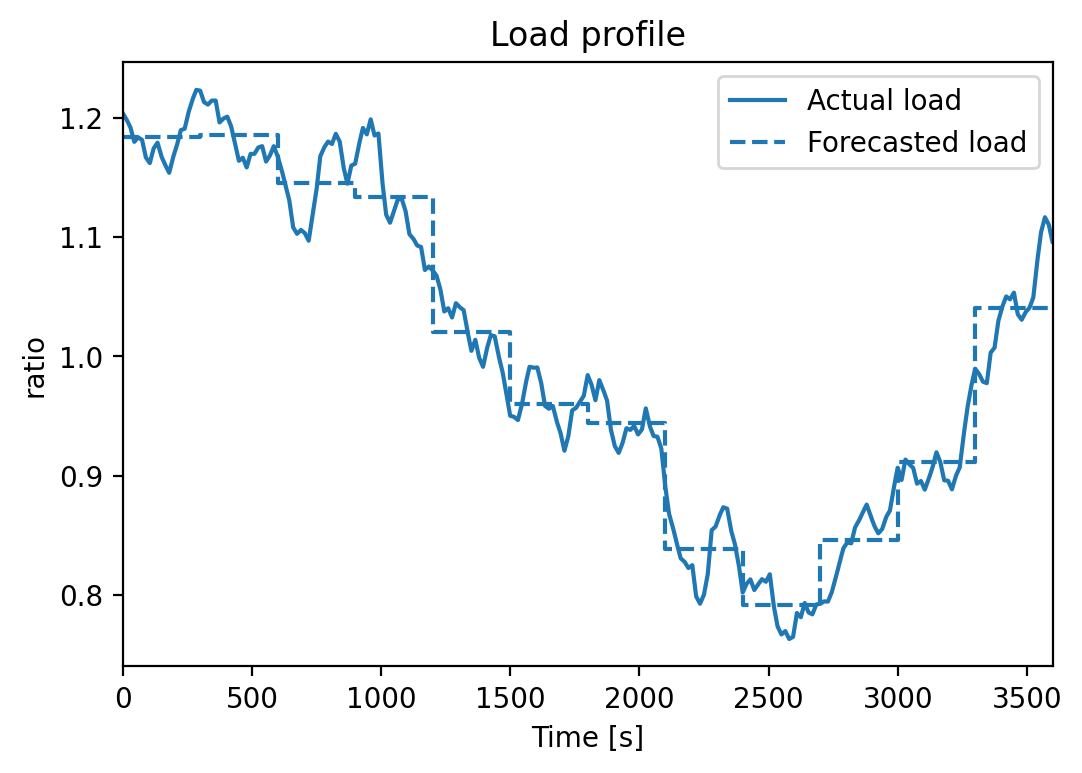

In [9]:
ptotal = ssa.PQ.as_df()['p0'].sum()
print('ANDES total load is:',ptotal.round(4),'p.u.')

# scale d_syn
ddata_path = '/case/d_syn2.csv'
ddata = dir_path + ddata_path
d_syn = pd.read_csv(ddata)

ratio = 100
d_syn['s10'] = (d_syn['h10'] - d_syn['h10'].mean()) / d_syn['h10'].var() * ratio + 1
# d_syn['s18'] = (d_syn['h18'] - d_syn['h18'].mean()) / d_syn['h18'].var() * ratio + 1
# compute the load forecast by averaging every 300s [5min]
step = 300
d_exp = d_syn.groupby(d_syn.index // step).mean().copy()
d_exp['time'] = range(0,3600,300)

print(d_exp.iloc[0:2])

fig_load, ax_load = plt.subplots()
ax_load.plot(d_syn['time'], d_syn['s10'], color='tab:blue', linestyle='-')
ystep = list(d_exp['s10'])
ystep.insert(0, d_exp['s10'].iloc[0])
ax_load.step(range(0,3900,300), ystep, color='tab:blue', linestyle='--')
ax_load.set_xlim([0, 3600])
ax_load.legend(['Actual load', 'Forecasted load'])
ax_load.set_title('Load profile')
ax_load.set_ylabel('ratio')
ax_load.set_xlabel('Time [s]')

## Setup ADNES model and PP net

Scale the ``ssa.PQ`` with initial synthetic load.

Scale the ``ss0.PQ`` with the initial expected load.

In [10]:
# scale load with the synthetic load
ssa_pq_bus = ssa.PQ.bus.v
ssa_pq_idx = ssa.PQ.find_idx(keys='bus', values=ssa_pq_bus)
ssa_pq_p0 = ssa.PQ.get(src='p0', idx=ssa_pq_idx, attr='v')
ssa_pq_q0 = ssa.PQ.get(src='q0', idx=ssa_pq_idx, attr='v')
ssa.PQ.set(src='p0', idx=ssa_pq_idx, attr='v', value=ssa_pq_p0 * d_syn['s10'].iloc[0])
ssa.PQ.set(src='q0', idx=ssa_pq_idx, attr='v', value=ssa_pq_q0 * d_syn['s10'].iloc[0])
ss0.PQ.set(src='p0', idx=ssa_pq_idx, attr='v', value=ssa_pq_p0 * d_exp['s10'].iloc[0])
ss0.PQ.set(src='q0', idx=ssa_pq_idx, attr='v', value=ssa_pq_q0 * d_exp['s10'].iloc[0])

True

Convert ``ss0`` to pandapower net ``ssp``, add linear gen_cost.

In [13]:
ssa.GENROU.as_df()

,idx,u,name,bus,gen,coi,coi2,Sn,Vn,fn,...,gammaq,xd,xq,xd2,xq1,xq2,Td10,Td20,Tq10,Tq20
uid,,,,,,,,,,,,,,,,,,,,,
0,GENROU_1,1.0,GENROU_1,30,PV_1,None,None,1040.0,34.5,60.0,...,1.0,0.096154,0.066346,0.000762,0.029808,0.000762,10.20,0.03,1.50,0.04
1,GENROU_2,1.0,GENROU_2,31,PV_2,None,None,836.0,34.5,60.0,...,1.0,0.352871,0.337321,0.035621,0.083373,0.035621,6.56,0.03,1.50,0.04
2,GENROU_3,1.0,GENROU_3,32,PV_3,None,None,843.7,21.0,60.0,...,1.0,0.295721,0.280906,0.003041,0.062937,0.003041,5.70,0.03,1.50,0.04
3,GENROU_4,1.0,GENROU_4,33,PV_4,None,None,1174.8,21.0,60.0,...,1.0,0.223017,0.219612,0.000684,0.037113,0.000684,5.69,0.03,1.50,0.04
4,GENROU_5,1.0,GENROU_5,34,PV_5,None,None,1080.2,15.5,60.0,...,1.0,0.620256,0.573968,0.000529,0.122200,0.000529,5.40,0.03,0.44,0.04
5,GENROU_6,1.0,GENROU_6,35,PV_6,None,None,1085.7,15.5,60.0,...,1.0,0.233950,0.221977,0.042865,0.046053,0.042865,7.30,0.03,0.40,0.04
6,GENROU_7,1.0,GENROU_7,36,PV_7,None,None,1025.2,12.5,60.0,...,1.0,0.287749,0.284822,0.002088,0.047796,0.002088,5.66,0.03,1.50,0.04
7,GENROU_8,1.0,GENROU_8,37,PV_8,None,None,970.2,12.5,60.0,...,1.0,0.298907,0.288600,0.006263,0.058751,0.006263,6.70,0.03,0.41,0.04
8,GENROU_9,1.0,GENROU_9,38,PV_9,None,None,1684.1,34.5,60.0,...,1.0,0.125052,0.121727,0.000697,0.033846,0.000697,4.79,0.03,1.96,0.04


In [14]:
# convert PP network
ssp = to_pandapower(ss0)

# add gen cost
gen_cost = np.array([
    [2, 0, 0, 3, 0.0, 0.3, 0.0],
    [2, 0, 0, 3, 0.0, 0.25, 0.0],
    [2, 0, 0, 3, 0.0, 0.25, 0.0],
    [2, 0, 0, 3, 0.0, 0.3, 0.0],
    [2, 0, 0, 3, 0.0, 0.3, 0.0],
    [2, 0, 0, 3, 0.0, 0.3, 0.0],
    [2, 0, 0, 3, 0.0, 0.3, 0.0],
    [2, 0, 0, 3, 0.0, 0.2, 0.0],
    [2, 0, 0, 3, 0.0, 0.5, 0.0],
    [2, 0, 0, 3, 0.0, 0.0, 0.0]
])

add_gencost(ssp, gen_cost)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.2175 seconds.
0: |F(x)| = 7.645417668
1: |F(x)| = 3.173448354
2: |F(x)| = 0.1609306789
3: |F(x)| = 0.0008867685258
4: |F(x)| = 1.850520093e-08
Converged in 5 iterations in 0.0083 seconds.
Power flow results are consistent. Conversion is successful.


True

In [15]:
pp.runopp(ssp)

OPFNotConverged: Optimal Power Flow did not converge!

Alter the StaticGen.

In [ ]:
ssa_key = make_link_table(ssa)
ssp_res0 = runopp_map(ssp, ssa_key)

ssa_stg_bus = ssp_res0['name'][~ssp_res0['stg_idx'].isna()].values.tolist()
ssa_stg_idx = ssa.StaticGen.find_idx(keys='name', values=ssa_stg_bus)
ssa_stg_p0 = ssa.StaticGen.get(src='p0', idx=ssa_stg_idx, attr='v')
ssa.StaticGen.set(src='p0', idx=ssa_stg_idx, attr='v', value=ssp_res0['p'][~ssp_res0['stg_idx'].isna()])

## Co-Sim

### Check OPF convergence

In [ ]:
# total length: 1h; 5min ed; 4s AGC;

t_total = 3600    # 3600s

intv_ed = 300  # ed interval, 300s

n_ed = ceil(t_total/intv_ed)

ssa_key = make_link_table(ssa)
agc_table = pd.DataFrame(columns=('idx', 'value'))

# collect OPF results
opf_resp = pd.DataFrame()
opf_resq = pd.DataFrame()
opf_resp['name'] = ssp.gen['name']
opf_resq['name'] = ssp.gen['name']

ssa_p0 = ssa.PQ.p0.v.copy()
ssa_pq_idx = ssa.PQ.idx.v

ssa.TDS.config.tf = 0  # reset the TDS end time
msg = True
# simulation loop
for idx_ed in range(n_ed):  # ed interval
    ssp.load['p_mw'] = ssa_p0 * d_exp['s10'].iloc[idx_ed] * ssp.sn_mva
    # OPF
    ssp_res = runopp_map(ssp, ssa_key)
    opf_resp = pd.concat([opf_resp, ssp_res[['p']].rename(columns={'p':f'ED{idx_ed}'})], axis=1)
opf_resp

In [ ]:
fig_dp, ax_dp = plt.subplots()

total_p0 = ssa_p0.sum()

ax_dp.plot(d_syn['time'], d_syn['s10'] * total_p0, color='tab:blue')
ystep = list(d_exp['s10'])
ystep.insert(0, d_exp['s10'].iloc[0])
ax_dp.step(range(0,3900,300), np.array(ystep) * total_p0, color='tab:blue', linestyle='--')
ax_dp.set_xlim([0, 3600])

ystep2 = list(opf_resp.sum().values[1:13])
ystep2.insert(0, ystep2[0])
ax_dp.step(range(0,3900,300), ystep2, color='tab:orange')

ax_dp.set_title('Dispatch results')
ax_dp.legend(['Actual load', 'Forecasted load', 'Dispatch generation'])
ax_dp.set_xlabel('Time [s]')
ax_dp.set_ylabel('p.u.')

### ADENS power flow

In [ ]:
ssa.PQ.config.p2p = 1
ssa.PQ.config.q2q = 1
ssa.PQ.config.p2z = 0
ssa.PQ.config.q2z = 0
ssa.PQ.pq2z = 0

ssa.PFlow.run()

### Full loop

Total time: 3600s (1h)

RTED 300s (5min): (1) update load forecast in pp, read generator setpoints from `SynGen.Pe.v`, run ACOPF, (2) update setpoints into `TurbineGov.pref0`.

AGC: 4s: compute AGC, and update AGC into `TurbineGov.paux0`.

PQ and ACE: 1s, (1) alter load, update PQ into `PQ.Ppf` and `PQ.Qpf`, (2) run TDS, (3) update ACE.

TODO:

1) compute load in ``ssp`` with the average of next RTED interval rather than set down ahead
1) smooth setpoints
1) solve SFR with DCOPF, solve pref with ACOPF, results of pref can be compared between DC and AC

In [ ]:
# define constants
t_total = 3600    # 3600s

intv_ed = 300  # RTED interval, 300s
intv_agc = 4    # AGC interval, 4s
intv_pq = 1     # PQ interval, 1s; alter load and AGC
intv_step = 100 # step change interval; smooth the setpoitns

n_ed = int(t_total/intv_ed)
n_agc = int(intv_ed/intv_agc)
n_pq = int(intv_agc/intv_pq)
n_step = floor(intv_step/intv_agc)

# ACE vars
ACE_integral = 0
ACE_raw = 0
Kp = 0.1
Ki = 0.1

# idx of devices, only those in the OPF resutls are list here

ssa_gov_idx = list(ssp_res0['gov_idx'][~ssp_res0['gov_idx'].isna()])

# AGC table
agc_table = pd.DataFrame()
agc_table['gov_idx'] = ssa_gov_idx
agc_table['paux'] = 0
agc_res = agc_table[['gov_idx']].copy()

# collect OPF results
opf_resp = pd.DataFrame()
opf_resp['name'] = ssp.gen['name']

# simulation loop
for end_time in tqdm(range(t_total), desc='Co-Sim'):
    if end_time % intv_ed == 0:  # RTED
        idx_ed = end_time // intv_ed
        # update load forecast with the average load in the next RTED interval
        load_exp = d_syn['s10'].iloc[idx_ed*intv_ed:(idx_ed*intv_ed + intv_ed)].mean()
        ssp.load['p_mw'] = ssa_pq_p0 * load_exp * ssp.sn_mva
        ssp.load['q_mvar'] = ssa_pq_q0 * load_exp * ssp.sn_mva

        if end_time > 0:
            # TODO: get setpoints from TDS SynGen.Pe or TurbineGov.Pref
            popf0 = popf.copy()

        # RUN ACOPF, update setpoints
        ssp_res = runopp_map(ssp, ssa_key)
        opf_resp[f'{idx_ed}'] = ssp_res['p']
        popf = ssp_res['p'][~ssp_res['gov_idx'].isna()]

    if end_time % intv_agc == 0:
        idx_agc = end_time // intv_agc - idx_ed * n_agc
        # TODO: update AGC equation with computed beta
        agc_table['paux'] = ACE_raw*(1/10)*np.ones(len(agc_table))
        agc_res[f'{idx_agc}'] = agc_table['paux']
        # DO AGC
        ssa.TurbineGov.set(src='paux0', idx=ssa_gov_idx, attr='v',
                           value=agc_table['paux'].values)
        # smooth setpoints:
        if idx_ed == 0:
            pgov = popf.copy()
        else:
            idx_step = min((end_time - idx_ed * intv_ed) // intv_agc + 1, n_step)
            pgov = popf0 + (popf - popf0) / n_step * idx_step
        # update setpoints
        ssa.TurbineGov.set(src='pref0', idx=ssa_gov_idx, attr='v', value=pgov)

    # intv_pq: alter load, run TDS
    ssa.PQ.set(src='Ppf', idx=ssa_pq_idx, attr='v',
                value=ssa_pq_p0 * d_syn['s10'].iloc[end_time])
    ssa.PQ.set(src='Qpf', idx=ssa_pq_idx, attr='v',
                value=ssa_pq_q0 * d_syn['s10'].iloc[end_time])
    # RUN TDS
    ssa.TDS.config.tf = end_time
    ssa.TDS.run()
    # ACE calculation
    ACE_integral = ACE_integral + ssa.ACEc.ace.v
    ACE_raw = -(Kp*ssa.ACEc.ace.v + Ki*ACE_integral)
    ACE_raw = 0  # delete when run TDS
    # break loop if TDS run into error
    if ssa.exit_code != 0:
        print(f"TDS run into error! exit_code {ssa.exit_code}")
        break

Check the TDS exit_code

In [ ]:
if ssa.exit_code == 0:
    print("TDS run well.")
else:
    print("TDS run into error, please check!")

### Results

In [ ]:
color=['tab:blue', 'tab:orange', 'tab:green',
       'tab:red', 'tab:purple']
right=t_total
fig_gov, ax_gov = ssa.TDS.plt.plot(ssa.TGOV1N.pout,
                                   right=right,
                                   linestyles=['-'],
                                   yheader=['Gov 1', 'Gov 2', 'Gov 3', 
                                            'Gov 4', 'Gov 5'],
                                   legend=True,
                                   color=color,
                                   title=r'Generation (solid: pout; dash: pref)',
                                   ylabel='Active power [p.u.]',
                                   show=False)
fig_ref, ax_ref = ssa.TDS.plt.plot(ssa.TGOV1N.pref,
                                   right=right,
                                   legend=False,
                                   linestyles=['--'],
                                   color=color,
                                   fig=fig_gov, ax=ax_gov,)
# fig_gov

In [ ]:
fig_coi, ax_coi = ssa.TDS.plt.plot(ssa.COI.omega,
                                   ytimes=60, right=right,
                                   legend=False,
                                   title='COI frequency',
                                   ylabel='Hz')

In [ ]:
wcoi_tds = ssa.dae.ts.y[:, ssa.COI.omega.a].reshape(-1).copy() * ssa.config.freq
wcoi_df = pd.DataFrame()
wcoi_df['wcoi'] = wcoi_tds
ax_wcoi = wcoi_df.plot.kde(legend=False)
print("mean(COI_freq)=", wcoi_tds.mean())
ax_wcoi.set_title('COI frequency')
ax_wcoi.set_ylabel('Density')
ax_wcoi.set_xlabel('Hz')

In [ ]:
fig_ace, ax_ace = ssa.TDS.plt.plot(ssa.ACEc.ace,
                                   right=right,
                                   legend=False,
                                   title='ACE',
                                   ylabel='p.u.')

In [ ]:
ace_tds = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1).copy()
ace_df = pd.DataFrame()
ace_df['ace'] = ace_tds
ax_ace = ace_df.plot.kde(legend=False)
ax_ace.set_title('ACE Density')
ax_ace.set_ylabel('Density')
ax_ace.set_xlabel('Deviation [p.u.]')